
# Welcome to our Notebook 
### Volatile Bandits: Noisy, imperfect but efficient: SMC agents for modelling human behaviour

<img src='images_and_figures/bandit_illustration.png' width='800'>

This notebook reproduces the biologically plausible **forward varying-volatility** agent and the **Weber-imprecision** agent from Findling et al. (2021) paper titled *'Imprecise neural computations as a source of adaptive behaviour in volatile environments'*. It comprises three sections: 
1. a playground to first build some intuitions -> *interactive* 
2. the codebase for building and running the two-armed bandit experiment from the paper -> *not interactive, skip if there is no time* 
3. and comparing this to human data you made from the seminar demo! -> *interactive*

*By: Sabine, Sigur, Sofia and Elena*

```
Folder Structure 

neural-imprecision-for-volatility/     
└── findling_notebook/                 ←📍OUR REPO
    ├── notebook.ipynb               
    ├── images_and_figures/            
    └── participant_data/              
        └── backup_combined_data.csv
├── fit_functions/                     ← Original C++ code - you can ignore these files
├── lib_c/                             
├── simulation_functions/              
└── utils/                             

```
________________________________________________________________________________


# Colab Setup - Run this first!

In [84]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("📍 Running in Google Colab!")
    print("=" * 50)
    
    # GitHub repository info:
    GITHUB_USER = "sascholle"
    GITHUB_REPO = "neural-imprecision-for-volatility"
    NOTEBOOK_FOLDER = "findling_notebook"  # ← Folder containing the notebook
    
    # Step 1: Install/enable widgets
    try:
        import subprocess
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "ipywidgets"], 
                      capture_output=True)  # Don't fail if already installed
    except:
        pass  # ipywidgets likely already available
    
    from google.colab import output
    output.enable_custom_widget_manager()
    print("✅ Widgets ready")
    
    # Step 2: Clone the repository (always fresh to get latest version)
    repo_path = f"/content/{GITHUB_REPO}"
    if os.path.exists(repo_path):
        print("🔄 Removing old version...")
        import shutil
        shutil.rmtree(repo_path)
    
    # Change to /content/ first, then clone
    os.chdir("/content")
    print("📥 Cloning latest version from GitHub...")
    clone_result = os.system(f"git clone https://github.com/{GITHUB_USER}/{GITHUB_REPO}.git")
    
    if clone_result != 0 or not os.path.exists(repo_path):
        print("❌ Clone failed! Check the repository URL.")
        raise Exception("Git clone failed")
    
    print("✅ Repository cloned")
    
    # Step 3: Navigate to notebook folder
    notebook_path = f"{repo_path}/{NOTEBOOK_FOLDER}"
    os.chdir(notebook_path)
    print(f"✅ Working directory: {notebook_path}")
    
    # Step 4: Verify files exist
    print("\n📁 Checking files...")
    checks = [
        ("images_and_figures/bandit_illustration.png", "Banner image"),
        ("images_and_figures/model_schemas.jpg", "Model diagram"),
        ("images_and_figures/varyingvolfull.png", "Var-Vol diagram"),
        ("participant_data", "Participant data folder"),
    ]
    all_good = True
    for path, name in checks:
        if os.path.exists(path):
            print(f"   ✅ {name}")
        else:
            print(f"   ❌ {name} - NOT FOUND")
            all_good = False
    
    if all_good:
        print("\n🎉 All set! You can run the rest of the notebook.")
    else:
        print("\n⚠️ Some files missing. Check your GitHub repo structure.")

else:
    print("📍 Running locally - no Colab setup needed!")
    print(f"   Working directory: {os.getcwd()}")


📍 Running locally - no Colab setup needed!
   Working directory: c:\Users\beani\Documents\MSc\Semester1\DecisionMaking\learning_variability_and_volatility\findling_notebook


### Quickstart
1. Use the search function for the words **'To Do'** to jump to the 5 sections where you can interact with the codebase, you can often just skip the rest if you're pressed for time. Make sure Section 1 and 2 are uncollapsed to find them with search.
2. If you are on a local machine, run `pip install numpy scipy matplotlib pandas ipywidgets` once in your environment.


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings("ignore", message="Glyph.*missing from font")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)


# Section 1: Build-a-Model Playground 

First let's see what we need to build a model of human behaviour. We look at two of the models from the paper, the **varying volatiltiy model**, and the novel **Weber-imprecision model**. Here is an overview of all of them from the paper:

<img src="images_and_figures/model_schemas.jpg" width="900" style="display:inline">

### Model Variables at a Glance
In the 2-armed bandit demo you did earlier:
- **Two circles** (🟠 Orange and 🔵 Blue) = the two **actions** to choose from

| Symbol | Name | Model | In your demo | What it controls |
|--------|------|-------|--------------|------------------|
| **z_t** | Latent state | Both | 🟠=0 or 🔵=1 | Which circle is currently "correct" |
| **a_t** | Action | Both | Circle clicked | Which circle the participant chose |
| **r_t** | Reward | Both | 😊 or 😠 | Feedback shown after choice |
| **η** (eta) | Feedback noise | Both | (hidden) | How reliable is the 😊/😠 feedback? |
| **s_t** | Stimulus | Both | 0 | Always 0 in 2-armed bandit (no varying stimulus) |
| **ν** (nu) | Volatility variance | Var-Vol only | (hidden) | How *quickly* τ changes over time |
| **τ_t** (tau) | Switch probability | Var-Vol only | (hidden) | Chance the correct circle flips this trial |
| **λ** (lambda) | Weber scaling | Weber only | (hidden) | Noise scales with belief change: `noise = λ × Δbelief` |
| **μ** (mu) | Baseline noise | Weber only | (hidden) | Minimum noise added every trial |
| **ε_t** | Inference noise | Weber only | (hidden) | Total noise: `ε_t = λ × Δbelief + μ` |

**Key insight**: The Weber model replaces explicit volatility tracking (ν, τ) with simple noise injection (λ, μ). When beliefs shift rapidly, noise increases — mimicking what volatility estimation would achieve, but computationally cheaper.



### 🧠 To Do: Quick Quiz

| Question | Var-Vol | Weber |
|----------|---------|-------|
| 1. Does it track volatility explicitly? | _____ | _____ |
| 2. How does it adapt after a switch? | _____ | _____ |
| 3. Computational cost? | _____ | _____ |
| 4. Which parameters does it use? | _____ | _____ |
| 5. More biologically plausible? | _____ | _____ |

<details>
<summary>💡 Click for answers</summary>

| Aspect | Varying-Volatility | Weber-Imprecision |
|--------|-------------------|-------------------|
| **1. Tracks volatility?** | ✅ Yes (maintains τ_t, ν) | ❌ No |
| **2. Adapts to switches?** | Via Bayesian inference on τ | Via noise injection (ε_t) |
| **3. Computational cost** | 🐢 Heavy (nested SMC²) | Light (single SMC) |
| **4. Parameters** | ν, τ_min, τ_max, η | λ, μ, η |
| **5. Biological plausibility** | Less (requires precise computation) | More (noise is "free") |

**Why is Weber more biologically plausible?** The brain doesn't need to compute exact Bayesian posteriors — it just needs to be "noisier" when things are uncertain. Weber achieves similar behavior through a simple heuristic!

</details>



### 🧠 To Do: Test out the sliders to see how the variables interact

In [86]:
def explore_environment(tau_min=0.0, tau_max=0.5, nu=1e-4, eta=0.9, 
                        lambda_weber=0.5, mu_weber=0.1, seed=42, num_trials=100):
    """
    Visualize the environment AND simplified model belief updates.
    Paper: τ ∈ [0, 0.5], ν constant, η ∈ [0.5, 1]
    This is a conceptual demo - not full SMC, but shows the key differences.
    """
    rng = np.random.default_rng(seed)
    
    # =========================================
    # GENERATE ENVIRONMENT
    # =========================================
    
    # Generate volatility τ_t (bounded random walk)
    tau = np.zeros(num_trials)
    tau[0] = tau_min
    for t in range(1, num_trials):
        tau[t] = np.clip(rng.normal(tau[t-1], np.sqrt(nu)), tau_min, tau_max)
    
    # Generate latent state z_t (switches with probability τ_t)
    z = np.zeros(num_trials, dtype=int)
    z[0] = rng.integers(2)
    switches = []
    for t in range(1, num_trials):
        if rng.random() < tau[t]:
            z[t] = 1 - z[t-1]
            switches.append(t)
        else:
            z[t] = z[t-1]
    
    # Generate traps (feedback noise)
    traps = rng.random(num_trials) > eta
    
    # =========================================
    # SIMULATE SIMPLIFIED BELIEF UPDATES
    # =========================================
    # Both models start with uniform belief P(z=1) = 0.5
    
    # Var-Vol model: uses estimated τ to weight new evidence
    belief_varvol = np.zeros(num_trials)
    belief_varvol[0] = 0.5
    tau_estimate = np.zeros(num_trials)  # Model's estimate of volatility
    tau_estimate[0] = (tau_min + tau_max) / 2
    
    # Weber model: injects noise proportional to belief change
    belief_weber = np.zeros(num_trials)
    belief_weber[0] = 0.5
    weber_noise = np.zeros(num_trials)  # Track injected noise
    
    # Learning rate for simplified updates
    base_lr = 0.3
    
    for t in range(1, num_trials):
        # Simulate what feedback they'd get if choosing based on belief
        action_varvol = 1 if belief_varvol[t-1] > 0.5 else 0
        action_weber = 1 if belief_weber[t-1] > 0.5 else 0
        
        # Get rewards (with traps)
        reward_varvol = int((action_varvol == z[t-1]) != traps[t-1])
        reward_weber = int((action_weber == z[t-1]) != traps[t-1])
        
        # === VAR-VOL UPDATE ===
        # Update τ estimate based on prediction error
        prediction_error = abs(reward_varvol - (1 if action_varvol == int(belief_varvol[t-1] > 0.5) else 0))
        tau_estimate[t] = np.clip(
            tau_estimate[t-1] + 0.1 * (prediction_error - tau_estimate[t-1]) + rng.normal(0, np.sqrt(nu)),
            tau_min, tau_max
        )
        # Learning rate scales with estimated volatility
        lr_varvol = base_lr * (1 + 2 * tau_estimate[t])
        # Update belief
        if reward_varvol == 1:
            target = 1.0 if action_varvol == 1 else 0.0
        else:
            target = 0.0 if action_varvol == 1 else 1.0
        # Weight by feedback reliability
        effective_lr = lr_varvol * eta
        belief_varvol[t] = np.clip(belief_varvol[t-1] + effective_lr * (target - belief_varvol[t-1]), 0.01, 0.99)
        
        # === WEBER UPDATE ===
        # Standard update first
        if reward_weber == 1:
            target = 1.0 if action_weber == 1 else 0.0
        else:
            target = 0.0 if action_weber == 1 else 1.0
        effective_lr = base_lr * eta
        new_belief = belief_weber[t-1] + effective_lr * (target - belief_weber[t-1])
        
        # Inject Weber noise: ε = λ * |Δbelief| + μ
        delta_belief = abs(new_belief - belief_weber[t-1])
        weber_noise[t] = lambda_weber * delta_belief + mu_weber
        
        # Add noise (pushes belief toward 0.5 = uncertainty)
        noise_direction = 0.5 - new_belief  # toward center
        belief_weber[t] = np.clip(new_belief + weber_noise[t] * noise_direction * rng.random(), 0.01, 0.99)
    
    # === PLOTTING ===
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    
    # Plot 1: Environment - True volatility and latent state
    ax1 = axes[0]
    for sw in switches:
        ax1.axvline(sw, color="red", alpha=0.7, linewidth=1, linestyle="--")
    for t in range(num_trials - 1):
        color = "#f39c12" if z[t] == 0 else "#3498db"
        ax1.axvspan(t, t+1, alpha=0.2, color=color)
    ax1.fill_between(range(num_trials), tau, alpha=0.4, color="purple")
    ax1.plot(tau, color="purple", linewidth=2, label="True τ_t")
    ax1.axhline(tau_min, color="gray", linestyle=":", alpha=0.5)
    ax1.axhline(tau_max, color="gray", linestyle=":", alpha=0.5)
    ax1.set_ylabel("Volatility τ")
    ax1.set_title(f"① ENVIRONMENT: ν={nu:.0e}, η={eta:.0%} | {len(switches)} switches (red dashed)")
    ax1.set_ylim(0, 0.4)
    ax1.legend(loc="upper right")
    
    # Plot 2: Var-Vol model beliefs and τ estimate
    ax2 = axes[1]
    for sw in switches:
        ax2.axvline(sw, color="red", alpha=0.3, linewidth=1, linestyle="--")
    ax2.fill_between(range(num_trials), 0.5, belief_varvol, alpha=0.3, color="#1f77b4",
                     where=belief_varvol >= 0.5, label="Believes Blue")
    ax2.fill_between(range(num_trials), belief_varvol, 0.5, alpha=0.3, color="#f39c12",
                     where=belief_varvol < 0.5, label="Believes Orange")
    ax2.plot(belief_varvol, color="#1f77b4", linewidth=2, label="P(Blue correct)")
    ax2.plot(tau_estimate, color="purple", linewidth=1, linestyle="--", alpha=0.7, label="τ estimate")
    ax2.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
    ax2.set_ylabel("Belief")
    ax2.set_ylim(0, 1)
    ax2.set_title(f"② VAR-VOL MODEL: Tracks volatility → adjusts learning rate")
    ax2.legend(loc="upper right", fontsize=8)
    
    # Plot 3: Weber model beliefs
    ax3 = axes[2]
    for sw in switches:
        ax3.axvline(sw, color="red", alpha=0.3, linewidth=1, linestyle="--")
    ax3.fill_between(range(num_trials), 0.5, belief_weber, alpha=0.3, color="#1f77b4",
                     where=belief_weber >= 0.5)
    ax3.fill_between(range(num_trials), belief_weber, 0.5, alpha=0.3, color="#f39c12",
                     where=belief_weber < 0.5)
    ax3.plot(belief_weber, color="#ff7f0e", linewidth=2, label="P(Blue correct)")
    ax3.axhline(0.5, color="gray", linestyle=":", alpha=0.5)
    ax3.set_ylabel("Belief")
    ax3.set_ylim(0, 1)
    ax3.set_title(f"③ WEBER MODEL (λ={lambda_weber}, μ={mu_weber}): Injects noise when beliefs change")
    ax3.legend(loc="upper right", fontsize=8)
    
    # Plot 4: Weber noise magnitude over time
    ax4 = axes[3]
    for sw in switches:
        ax4.axvline(sw, color="red", alpha=0.3, linewidth=1, linestyle="--")
    ax4.fill_between(range(num_trials), weber_noise, alpha=0.4, color="#ff7f0e")
    ax4.plot(weber_noise, color="#ff7f0e", linewidth=2, label=f"ε = λ×|Δbelief| + μ")
    ax4.axhline(mu_weber, color="gray", linestyle=":", alpha=0.5, label=f"Baseline μ={mu_weber}")
    ax4.set_ylabel("Weber noise ε")
    ax4.set_xlabel("Trial")
    ax4.set_ylim(0, max(0.5, weber_noise.max() * 1.2))
    ax4.set_title(f"④ WEBER NOISE: Spikes when beliefs shift rapidly")
    ax4.legend(loc="upper right", fontsize=8)
    
    plt.tight_layout()
    
    # Summary
    acc_varvol = np.mean((belief_varvol > 0.5) == z)
    acc_weber = np.mean((belief_weber > 0.5) == z)
    print(f"Simplified accuracy — Var-Vol: {acc_varvol:.1%} | Weber: {acc_weber:.1%} | Switches: {len(switches)}")

try:
    from ipywidgets import interact, FloatSlider, IntSlider, FloatLogSlider
    
    print("ENVIRONMENT PARAMS (top) vs VAR-VOL (middle) vs WEBER PARAMS (bottom)")
    print("=" * 50)
    
    interact(
        explore_environment,
        # --- Environment parameters (Paper: τ ∈ [0, 0.5]) ---
        tau_min=FloatSlider(value=0.0, min=0.0, max=0.25, step=0.01, description="τ_min", continuous_update=False),
        tau_max=FloatSlider(value=0.5, min=0.1, max=0.5, step=0.05, description="τ_max", continuous_update=False),
        nu=FloatLogSlider(value=1e-4, base=10, min=-6, max=-2, step=0.5, description="ν (nu)", continuous_update=False),
        eta=FloatSlider(value=0.90, min=0.50, max=1.00, step=0.05, description="η (eta)", continuous_update=False),
        # --- Weber-specific parameters ---
        lambda_weber=FloatSlider(value=0.5, min=0.0, max=2.0, step=0.1, description="λ (Weber)", continuous_update=False),
        mu_weber=FloatSlider(value=0.1, min=0.0, max=0.5, step=0.05, description="μ (Weber)", continuous_update=False),
        # --- Simulation settings ---
        seed=IntSlider(value=42, min=1, max=100, step=1, description="Seed", continuous_update=False),
        num_trials=IntSlider(value=100, min=50, max=200, step=10, description="Trials", continuous_update=False),
    )
    
except ImportError:
    print("ipywidgets not available. Running with defaults:")
    explore_environment()


ENVIRONMENT PARAMS (top) vs VAR-VOL (middle) vs WEBER PARAMS (bottom)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='τ_min', max=0.25, step=0.01…

### 🧠 To Do: Quick Quiz

<img src="images_and_figures/varyingvolfull.png" width="500" style="display:inline">

1. **Which parameter controls how often the correct circle changes?**

2. **What does ν (nu) do?**

3. **How does η affect the feedback?**

4. **Why doesn't Weber have ν or τ?**
 

<details>
<summary>💡 Click for answers</summary>

1. **τ_max** — Higher max = more volatile = more switches between 🟠 and 🔵
2. **ν** controls how *quickly* τ changes. Large ν = τ jumps around; small ν = τ stays flat
3. **η** = feedback reliability. Lower η = more traps = sometimes 😊 when wrong, 😠 when right!
4. Weber trades explicit volatility tracking for simpler "noise injection" — computationally cheaper but less principled

</details>


# Section 2: Task generator - Closed two-armed Volatile Bandit

Next we will actually build and simulate the two-armed bandit task they reported in the paper. The latent state `z_t ∈ {0,1}` tells us which arm is currently correct. Volatility `τ_t` is the hazard that the correct arm changes. 
- `τ_t` performs a bounded Gaussian random walk between `tau_min` and `tau_max` with variance `ν`.
- When a switch happens, the new state is sampled from a Dirichlet prior `γ` that forbids staying on the same arm.
- Feedback noise `η` (called beta in the codebase) flips the reward on “trap” trials so that correct responses sometimes get punished and incorrect ones sometimes get rewarded.

Steps: 
1. Generate or hardcode **a task and build an environment** (i.e. when change points occur etc - this needs to be the same across models for comparing them later)
2. Build the **particle filtering SMC algorithm** (sequential Monte Carlo)
3. Create the **forward varying-volatility and Weber-imprecision agents**
4. **Run both agents** on the same task - this is the compute heavy part!


### Step 1: Task and environment generation

In [87]:
@dataclass
class VolatileBanditTask:
    """Container that stores a whole task instance for re-use across agents."""
    stimuli: np.ndarray  # here it is always zero but kept for completeness
    latent_states: np.ndarray  # z_t, the true task-set index
    switch_prob: np.ndarray  # τ_t
    traps: np.ndarray  # Bernoulli noise on rewards
    correct_actions: np.ndarray  # action that yields positive feedback if there is no trap
    beta: float  # feedback reliability parameter η in the paper


def generate_bandit_task(
    trial_num: int = 200,
    tau_min: float = 0.0,    # Paper: τ ∈ [0, 0.5]
    tau_max: float = 0.5,    # Paper: τ ∈ [0, 0.5]
    nu: float = 1e-4,        # Constant within a block; model infers it via Inv-Gamma(3, 0.001) prior
    beta: float = 0.9,       # η (feedback reliability); model infers via η/2 ~ Beta(1,1) → η ∈ [0.5,1]
    seed: Optional[int] = None,
) -> VolatileBanditTask:
    """Generate a single task trajectory following Findling et al. (2021) Methods.

    Paper specification:
    - τ_t varies as bounded Gaussian random walk in [0, 0.5] with variance ν
    - ν is constant within a block (model has Inv-Gamma(3, 0.001) prior)
    - When z_t changes, new state drawn from Dirichlet(1,...,1) excluding previous
    - Feedback: r_t ~ Bernoulli(η) if correct, Bernoulli(1-η) if incorrect

    Parameters
    ----------
    trial_num : int
        Number of interaction steps.
    tau_min, tau_max : float
        Lower/upper bounds for volatility τ. Paper uses [0, 0.5].
    nu : float
        Variance of the Gaussian random walk on τ. Constant within block.
    beta : float
        Feedback reliability η. Paper: η > 0.5, prior is η/2 ~ Beta(1,1).
    seed : int, optional
        RNG seed for reproducibility.
    """
    rng = np.random.default_rng(seed)
    stimuli = np.zeros(trial_num, dtype=int)  # one stimulus, two actions

    tau = np.zeros(trial_num)
    tau[0] = tau_min
    for t in range(1, trial_num):
        tau[t] = np.clip(rng.normal(tau[t - 1], np.sqrt(nu)), tau_min, tau_max)

    latent = np.zeros(trial_num, dtype=int)
    latent[0] = rng.integers(2)
    traps = rng.random(trial_num) > beta  # True = reward flips

    for t in range(1, trial_num):
        if rng.random() < tau[t]:
            latent[t] = 1 - latent[t - 1]  # with K=2, switching means flipping
        else:
            latent[t] = latent[t - 1]

    correct_actions = latent.copy()  # mapping is identity in the closed 2-armed case

    return VolatileBanditTask(
        stimuli=stimuli,
        latent_states=latent,
        switch_prob=tau,
        traps=traps,
        correct_actions=correct_actions,
        beta=beta,
    )


def generate_classroom_task(beta: float = 0.8, seed: int = 42) -> VolatileBanditTask:
    """
    🎓 HARDCODED TASK for classroom experiment comparison.
    
    This matches the exact trial structure used in the human demo:
    - Block 1: trials 1-14  (14 trials, z=0 Orange, STABLE)
    - Block 2: trials 15-23 (9 trials,  z=1 Blue,   VOLATILE - short!)
    - Block 3: trials 24-38 (15 trials, z=0 Orange, STABLE)
    - Block 4: trials 39-50 (12 trials, z=1 Blue,   MEDIUM)
    
    Switches occur at trials: 15, 24, 39
    Total: 50 trials
    
    Parameters
    ----------
    beta : float
        Feedback reliability η. Default 0.8 (80%) matches paper.
    seed : int
        RNG seed for trap trials (feedback noise). Task structure is fixed.
    """
    rng = np.random.default_rng(seed)
    
    # Block structure: (length, correct_answer)
    blocks = [
        (14, 0),  # Block 1: 14 trials, Orange (stable start)
        (9,  1),  # Block 2: 9 trials,  Blue   (volatile/short)
        (15, 0),  # Block 3: 15 trials, Orange (stable)
        (12, 1),  # Block 4: 12 trials, Blue   (medium)
    ]
    
    # Build latent state sequence
    latent = []
    for length, state in blocks:
        latent.extend([state] * length)
    latent = np.array(latent, dtype=int)
    
    trial_num = len(latent)  # 50
    stimuli = np.zeros(trial_num, dtype=int)
    
    # Traps (feedback noise) - only this is random
    traps = rng.random(trial_num) > beta
    
    # τ is not used for switches here (fixed structure), but we store block-level values
    # for visualization purposes
    tau = np.zeros(trial_num)
    tau[0:14] = 0.05    # Block 1: low volatility (stable)
    tau[14:23] = 0.15   # Block 2: high volatility (short block)
    tau[23:38] = 0.05   # Block 3: low volatility (stable)
    tau[38:50] = 0.10   # Block 4: medium volatility
    
    correct_actions = latent.copy()
    
    return VolatileBanditTask(
        stimuli=stimuli,
        latent_states=latent,
        switch_prob=tau,
        traps=traps,
        correct_actions=correct_actions,
        beta=beta,
    )


In [88]:
class TwoArmedBanditEnv:
    """Minimal environment that feeds the agents with stimuli and rewards."""

    def __init__(self, task: VolatileBanditTask):
        self.task = task
        self.index = 0

    def reset(self):
        self.index = 0

    def step(self, action: int) -> Tuple[int, int, int]:
        """Play one trial and return (stimulus, reward, correct_action)."""
        stimulus = self.task.stimuli[self.index]
        correct_action = self.task.correct_actions[self.index]
        trap = self.task.traps[self.index]

        if action == correct_action:
            reward = int(not trap)
        else:
            reward = int(trap)

        self.index += 1
        return stimulus, reward, correct_action


### Step 2: Particle filtering utilities - the sequential Monte Carlo (SMC) algorithm
*Reminder: a particle = a hypothesis about a parameter, weighted by how probable it is given observations*

The forward models in the repo maintain two layers of particles:

1. **State particles** encode beliefs over latent task-sets `z_t` and, for the varying-volatility agent, the latent hazard `τ_t`.
2. **Parameter particles** encode beliefs over the hyper-parameters `(β, ν, γ)` (varying volatility) or `(β, γ)` (Weber).

We reproduce the exact helper routines (stratified resampling, inverse-gamma sampling, etc.) here to keep the notebook self-contained.


In [89]:
def stratified_resample(weights: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """Stratified resampling as used in the original C++ code."""
    n = len(weights)
    cumulative = np.cumsum(weights)
    positions = (rng.random(n) + np.arange(n)) / n
    return np.searchsorted(cumulative, positions)


def sample_inv_gamma(shape: float, scale: float, size: int, rng: np.random.Generator) -> np.ndarray:
    """Inverse-gamma sampler matching utils/useful_functions.py."""
    return scale / rng.gamma(shape, size=size)


def logsumexp(log_w: np.ndarray) -> float:
    b = np.max(log_w)
    return b + np.log(np.sum(np.exp(log_w - b)))


def normalise_log_weights(log_w: np.ndarray) -> np.ndarray:
    """Convert log-weights to normalized weights without numerical trouble."""
    log_w = log_w - logsumexp(log_w)
    return np.exp(log_w)


def compute_positive_states(mapping: np.ndarray, stimulus: int, action: int, reward: int) -> np.ndarray:
    """Replicates isEqual_and_adapted_logical_xor from the C++ helpers."""
    equals = mapping[stimulus] == action
    if reward:  # reward==1 means the action was *reported* as correct
        return equals.astype(float)
    return (~equals).astype(float)


def sample_new_state_excluding(current: int, gamma: np.ndarray, rng: np.random.Generator) -> int:
    probs = gamma.copy()
    probs[current] = 0.0
    total = probs.sum()
    if total == 0:
        probs[:] = 1.0 / len(probs)
    else:
        probs /= total
    return rng.choice(len(probs), p=probs)



In [90]:
# Mapping between stimulus (rows) and correct action for each latent state (columns)
TASK_MAPPING = np.array([[0, 1]], dtype=int)
K = TASK_MAPPING.shape[1]  # number of latent states


### Step 3a: Forward varying-volatility agent
This class mirrors `simulation_functions/varvol_forward/SMC2.py` and `lib_c/varvol_forward/SMCfunctions.cpp`:
- Each *theta* particle samples `(β, ν, γ)`.
- Each theta carries `number_of_state_particles` state trajectories that track both latent task-set `z` and latent hazard `τ`.
- After every observation we:
  1. **Update weights** using the Bernoulli feedback likelihood.
  2. **Resample** state trajectories within each theta according to those weights.
  3. **Propagate** the trajectories by sampling a new `τ` and, with probability `τ`, switching to a different task-set drawn from `γ`.
  4. **Adapt** the parameter particles if the effective sample size (ESS) collapses.

The result is a biologically plausible online approximation of the exact SMC² solution.


In [91]:
class ForwardVaryingVolatilityAgent:
    """Forward (online) SMC approximation of the exact varying-volatility model."""

    def __init__(
        self,
        num_theta: int = 400, 
        num_state_particles: int = 200,
        tau_default: float = 0.03,
        tau_bounds: Tuple[float, float] = (0.0, 0.5),
        beta_prior: Tuple[float, float] = (1.0, 1.0),
        nu_prior: Tuple[float, float] = (3.0, 1e-3),
        gamma_prior: float = 1.0,
        ess_threshold: float = 0.5,
        beta_softmax: Optional[float] = None,
        epsilon_softmax: float = 0.0,
        seed: Optional[int] = None,
    ):
        self.num_theta = num_theta
        self.num_state_particles = num_state_particles
        self.tau_default = tau_default
        self.tau_bounds = tau_bounds
        self.beta_prior = beta_prior
        self.nu_prior = nu_prior
        self.gamma_prior = gamma_prior
        self.ess_threshold = ess_threshold
        self.beta_softmax = beta_softmax
        self.epsilon_softmax = epsilon_softmax
        self.rng = np.random.default_rng(seed)

        self._init_particles()

    def _init_particles(self):
        self.beta_samples = self.rng.beta(
            self.beta_prior[0], self.beta_prior[1], size=self.num_theta
        )
        self.nu_samples = sample_inv_gamma(
            self.nu_prior[0], self.nu_prior[1], size=self.num_theta, rng=self.rng
        )
        self.gamma_samples = self.rng.dirichlet(
            np.ones(K) * self.gamma_prior, size=self.num_theta
        )
        self.state_particles = self.rng.integers(
            K, size=(self.num_theta, self.num_state_particles)
        )
        self.tau_particles = np.full(
            (self.num_theta, self.num_state_particles), self.tau_default
        )
        self.log_theta_weights = np.zeros(self.num_theta)
        self.theta_weights = np.ones(self.num_theta) / self.num_theta
        self.pending_observation = None
        self.current_action = None
        self.current_stimulus = None
        self.trial_index = 0

        self.history = {
            "vol_mean": [],
            "beta_mean": [],
            "nu_mean": [],
            "ts_prob": [],
        }

    # ------------------------------------------------------------------
    # Agent interaction API
    # ------------------------------------------------------------------
    def act(self, stimulus: int) -> Tuple[int, np.ndarray]:
        self._maybe_smc_update()
        action_probs = self._action_distribution(stimulus)
        action = self._sample_action(action_probs)
        self.current_action = action
        self.current_stimulus = stimulus
        return action, action_probs

    def observe(self, reward: int):
        self.pending_observation = (
            self.current_stimulus,
            self.current_action,
            reward,
        )
        self.trial_index += 1

    # ------------------------------------------------------------------
    # SMC internals
    # ------------------------------------------------------------------
    def _maybe_smc_update(self):
        if self.pending_observation is None:
            return

        stimulus, action, reward = self.pending_observation
        prev_states = self.state_particles.copy()
        prev_taus = self.tau_particles.copy()

        positive_states = compute_positive_states(TASK_MAPPING, stimulus, action, reward)
        # Transform beta from [0,1] to [0.5,1] as in original code: betaSamples/2 + 0.5
        # This ensures feedback noise η > 0.5 (reward is more likely when action is correct)
        beta_transformed = self.beta_samples / 2.0 + 0.5
        beta_matrix = beta_transformed[:, None]
        state_pos = positive_states[prev_states]
        likelihoods = state_pos * beta_matrix + (1 - state_pos) * (1 - beta_matrix)
        likelihoods = np.clip(likelihoods, 1e-9, None)

        sum_weights = likelihoods.sum(axis=1)
        self.log_theta_weights += np.log(sum_weights / self.num_state_particles)
        weights_norm = likelihoods / sum_weights[:, None]

        new_states = np.empty_like(prev_states)
        new_taus = np.empty_like(prev_taus)
        for theta_idx in range(self.num_theta):
            ancestor_idx = stratified_resample(weights_norm[theta_idx], self.rng)
            new_states[theta_idx] = prev_states[theta_idx, ancestor_idx]
            new_taus[theta_idx] = prev_taus[theta_idx, ancestor_idx]

        noise = self.rng.normal(
            0.0,
            np.sqrt(self.nu_samples)[:, None],
            size=new_taus.shape,
        )
        tau_candidates = np.clip(
            new_taus + noise, self.tau_bounds[0], self.tau_bounds[1]
        )
        self.tau_particles = tau_candidates

        switch_mask = self.rng.random(size=new_states.shape) < tau_candidates
        propagated_states = new_states.copy()
        for theta_idx in range(self.num_theta):
            gamma = self.gamma_samples[theta_idx]
            indices = np.where(switch_mask[theta_idx])[0]
            for idx in indices:
                propagated_states[theta_idx, idx] = sample_new_state_excluding(
                    propagated_states[theta_idx, idx], gamma, self.rng
                )
        self.state_particles = propagated_states

        self.pending_observation = None
        self.theta_weights = normalise_log_weights(self.log_theta_weights)
        self._maybe_rejuvenate()
        self._record_history()

    def _maybe_rejuvenate(self):
        ess = 1.0 / np.sum(self.theta_weights ** 2)
        if ess >= self.ess_threshold * self.num_theta:
            return

        beta_mu = np.sum(self.theta_weights * self.beta_samples)
        beta_var = np.sum(self.theta_weights * (self.beta_samples - beta_mu) ** 2)
        beta_var = max(beta_var, 1e-6)
        beta_alpha = max(((1 - beta_mu) / beta_var - 1 / beta_mu) * beta_mu ** 2, 1.0)
        beta_beta = max(beta_alpha * (1 / beta_mu - 1), 1.0)

        nu_mu = np.sum(self.theta_weights * self.nu_samples)
        nu_var = np.sum(self.theta_weights * (self.nu_samples - nu_mu) ** 2)
        nu_var = max(nu_var, 1e-6)
        nu_alpha = nu_mu ** 2 / nu_var + 2.0
        nu_beta = nu_mu * (nu_alpha - 1)

        dirichlet_means = np.sum(
            self.theta_weights[:, None] * self.gamma_samples, axis=0
        )
        dirichlet_vars = np.sum(
            self.theta_weights[:, None] * (self.gamma_samples ** 2), axis=0
        ) - dirichlet_means ** 2
        dirichlet_vars = np.clip(dirichlet_vars, 1e-6, None)
        dirichlet_precision = (
            np.sum(dirichlet_means - dirichlet_means ** 2) / np.sum(dirichlet_vars)
        ) - 1
        dirichlet_precision = max(dirichlet_precision, 1.0)
        dirichlet_params = np.maximum(
            dirichlet_means * dirichlet_precision, 1.0
        )

        self.beta_samples = self.rng.beta(
            beta_alpha, beta_beta, size=self.num_theta
        )
        self.nu_samples = sample_inv_gamma(
            nu_alpha, nu_beta, size=self.num_theta, rng=self.rng
        )
        self.gamma_samples = self.rng.dirichlet(
            dirichlet_params, size=self.num_theta
        )
        self.log_theta_weights[:] = 0.0
        self.theta_weights = np.ones(self.num_theta) / self.num_theta

    def _record_history(self):
        tau_means = self.tau_particles.mean(axis=1)
        vol_mean = np.sum(self.theta_weights * tau_means)
        beta_mean = np.sum(self.theta_weights * self.beta_samples)
        nu_mean = np.sum(self.theta_weights * self.nu_samples)
        ts_prob = self._taskset_probability(self.theta_weights)

        self.history["vol_mean"].append(vol_mean)
        self.history["beta_mean"].append(beta_mean)
        self.history["nu_mean"].append(nu_mean)
        self.history["ts_prob"].append(ts_prob)

    # ------------------------------------------------------------------
    # Decision policy helpers
    # ------------------------------------------------------------------
    def _taskset_probability(self, theta_weights: np.ndarray) -> np.ndarray:
        ts_prob = np.zeros(K)
        for theta_idx in range(self.num_theta):
            counts = np.bincount(
                self.state_particles[theta_idx], minlength=K
            ) / self.num_state_particles
            ts_prob += theta_weights[theta_idx] * counts
        ts_prob /= np.sum(ts_prob)
        return ts_prob

    def _action_distribution(self, stimulus: int) -> np.ndarray:
        ts_prob = self._taskset_probability(self.theta_weights)
        action_probs = np.zeros(2)
        for action in range(2):
            mask = TASK_MAPPING[stimulus] == action
            action_probs[action] = ts_prob[mask].sum()
        if self.beta_softmax is None:
            greedy_action = np.argmax(action_probs)
            probs = np.zeros_like(action_probs)
            probs[greedy_action] = 1.0
            return probs
        logits = action_probs * self.beta_softmax
        logits -= np.max(logits)
        probs = np.exp(logits)
        probs /= probs.sum()
        probs = probs * (1 - self.epsilon_softmax) + self.epsilon_softmax / len(probs)
        return probs

    def _sample_action(self, action_probs: np.ndarray) -> int:
        if np.isclose(action_probs.sum(), 0):
            return self.rng.integers(2)
        if np.count_nonzero(action_probs) == 1:
            return int(np.argmax(action_probs))
        return self.rng.choice(len(action_probs), p=action_probs)



### Step 3b: Weber-imprecision agent
The zero-volatility model assumes that the hazard `τ` is fixed (no environmental switches). The Weber-imprecision variant injects noise directly into the particle filter:
- Each theta particle still tracks `(β, γ)`.
- After observing a reward we compute the *distance* `d_t` between the pre-update (`ante`) and post-update (`post`) task-set beliefs (L1 distance, as in the C++ backend).
- The particle mis-encodes the next state with probability `ε_t ~ U(0, μ + λ d_t)`. When a mis-encoding happens the state particle is redrawn from `γ`.

Setting `μ = 0` and `λ = 0` collapses the model back to the deterministic zero-volatility case.


In [92]:
class WeberImprecisionAgent:
    """Forward Weber-imprecision agent (aka precision model)."""

    def __init__(
        self,
        num_theta: int = 400,
        num_state_particles: int = 200,
        lambdaa: float = 0.9,
        mu: float = 0.05,
        beta_prior: Tuple[float, float] = (1.0, 1.0),
        gamma_prior: float = 1.0,
        ess_threshold: float = 0.5,
        beta_softmax: Optional[float] = None,
        epsilon_softmax: float = 0.0,
        seed: Optional[int] = None,
    ):
        self.num_theta = num_theta
        self.num_state_particles = num_state_particles
        self.lambdaa = lambdaa
        self.mu = mu
        self.beta_prior = beta_prior
        self.gamma_prior = gamma_prior
        self.ess_threshold = ess_threshold
        self.beta_softmax = beta_softmax
        self.epsilon_softmax = epsilon_softmax
        self.rng = np.random.default_rng(seed)

        self._init_particles()

    def _init_particles(self):
        self.beta_samples = self.rng.beta(
            self.beta_prior[0], self.beta_prior[1], size=self.num_theta
        )
        self.gamma_samples = self.rng.dirichlet(
            np.ones(K) * self.gamma_prior, size=self.num_theta
        )
        self.state_particles = self.rng.integers(
            K, size=(self.num_theta, self.num_state_particles)
        )
        self.log_theta_weights = np.zeros(self.num_theta)
        self.theta_weights = np.ones(self.num_theta) / self.num_theta
        self.pending_observation = None
        self.current_action = None
        self.current_stimulus = None

        self.history = {
            "epsilon": [],
            "beta_mean": [],
            "ts_prob": [],
        }

    def act(self, stimulus: int) -> Tuple[int, np.ndarray]:
        self._maybe_smc_update()
        action_probs = self._action_distribution(stimulus)
        action = self._sample_action(action_probs)
        self.current_action = action
        self.current_stimulus = stimulus
        return action, action_probs

    def observe(self, reward: int):
        self.pending_observation = (
            self.current_stimulus,
            self.current_action,
            reward,
        )

    def _maybe_smc_update(self):
        if self.pending_observation is None:
            return

        stimulus, action, reward = self.pending_observation
        prev_states = self.state_particles.copy()

        positive_states = compute_positive_states(TASK_MAPPING, stimulus, action, reward)
        # Transform beta from [0,1] to [0.5,1] as in original code: betaSamples/2 + 0.5
        # This ensures feedback noise η > 0.5 (reward is more likely when action is correct)
        beta_transformed = self.beta_samples / 2.0 + 0.5
        beta_matrix = beta_transformed[:, None]
        state_pos = positive_states[prev_states]
        likelihoods = state_pos * beta_matrix + (1 - state_pos) * (1 - beta_matrix)
        likelihoods = np.clip(likelihoods, 1e-9, None)

        ante_counts = (
            np.apply_along_axis(
                lambda row: np.bincount(row, minlength=K), 1, prev_states
            )
            / self.num_state_particles
        )
        weighted_post = np.zeros_like(ante_counts)
        sum_weights = likelihoods.sum(axis=1)
        weights_norm = likelihoods / sum_weights[:, None]
        for theta_idx in range(self.num_theta):
            for state_idx in range(self.num_state_particles):
                s = prev_states[theta_idx, state_idx]
                weighted_post[theta_idx, s] += weights_norm[theta_idx, state_idx]

        weighted_post = np.divide(
            weighted_post,
            weighted_post.sum(axis=1, keepdims=True) + 1e-12,
        )

        distances = np.sum(np.abs(ante_counts - weighted_post), axis=1)
        epsilons = np.clip(self.mu + self.lambdaa * distances, 0.0, 1.0) / 2.0
        self.history["epsilon"].append(epsilons.mean())

        self.log_theta_weights += np.log(sum_weights / self.num_state_particles)

        new_states = np.empty_like(prev_states)
        for theta_idx in range(self.num_theta):
            ancestor_idx = stratified_resample(weights_norm[theta_idx], self.rng)
            candidates = prev_states[theta_idx, ancestor_idx]
            keep_mask = self.rng.random(self.num_state_particles) > epsilons[theta_idx]
            for s_idx in range(self.num_state_particles):
                if keep_mask[s_idx]:
                    new_states[theta_idx, s_idx] = candidates[s_idx]
                else:
                    new_states[theta_idx, s_idx] = self.rng.choice(
                        K, p=self.gamma_samples[theta_idx]
                    )
        self.state_particles = new_states

        self.pending_observation = None
        self.theta_weights = normalise_log_weights(self.log_theta_weights)
        self._maybe_rejuvenate()
        self._record_history()

    def _maybe_rejuvenate(self):
        ess = 1.0 / np.sum(self.theta_weights ** 2)
        if ess >= self.ess_threshold * self.num_theta:
            return

        beta_mu = np.sum(self.theta_weights * self.beta_samples)
        beta_var = np.sum(self.theta_weights * (self.beta_samples - beta_mu) ** 2)
        beta_var = max(beta_var, 1e-6)
        beta_alpha = max(((1 - beta_mu) / beta_var - 1 / beta_mu) * beta_mu ** 2, 1.0)
        beta_beta = max(beta_alpha * (1 / beta_mu - 1), 1.0)

        dirichlet_means = np.sum(
            self.theta_weights[:, None] * self.gamma_samples, axis=0
        )
        dirichlet_vars = np.sum(
            self.theta_weights[:, None] * (self.gamma_samples ** 2), axis=0
        ) - dirichlet_means ** 2
        dirichlet_vars = np.clip(dirichlet_vars, 1e-6, None)
        dirichlet_precision = (
            np.sum(dirichlet_means - dirichlet_means ** 2) / np.sum(dirichlet_vars)
        ) - 1
        dirichlet_precision = max(dirichlet_precision, 1.0)
        dirichlet_params = np.maximum(
            dirichlet_means * dirichlet_precision, 1.0
        )

        self.beta_samples = self.rng.beta(
            beta_alpha, beta_beta, size=self.num_theta
        )
        self.gamma_samples = self.rng.dirichlet(
            dirichlet_params, size=self.num_theta
        )
        self.log_theta_weights[:] = 0.0
        self.theta_weights = np.ones(self.num_theta) / self.num_theta

    def _record_history(self):
        beta_mean = np.sum(self.theta_weights * self.beta_samples)
        ts_prob = self._taskset_probability()
        self.history["beta_mean"].append(beta_mean)
        self.history["ts_prob"].append(ts_prob)

    def _taskset_probability(self) -> np.ndarray:
        ts_prob = np.zeros(K)
        for theta_idx in range(self.num_theta):
            counts = np.bincount(
                self.state_particles[theta_idx], minlength=K
            ) / self.num_state_particles
            ts_prob += self.theta_weights[theta_idx] * counts
        ts_prob /= np.sum(ts_prob)
        return ts_prob

    def _action_distribution(self, stimulus: int) -> np.ndarray:
        ts_prob = self._taskset_probability()
        action_probs = np.zeros(2)
        for action in range(2):
            mask = TASK_MAPPING[stimulus] == action
            action_probs[action] = ts_prob[mask].sum()
        if self.beta_softmax is None:
            greedy_action = np.argmax(action_probs)
            probs = np.zeros_like(action_probs)
            probs[greedy_action] = 1.0
            return probs
        logits = action_probs * self.beta_softmax
        logits -= np.max(logits)
        probs = np.exp(logits)
        probs /= probs.sum()
        probs = probs * (1 - self.epsilon_softmax) + self.epsilon_softmax / len(probs)
        return probs

    def _sample_action(self, action_probs: np.ndarray) -> int:
        if np.isclose(action_probs.sum(), 0):
            return self.rng.integers(2)
        if np.count_nonzero(action_probs) == 1:
            return int(np.argmax(action_probs))
        return self.rng.choice(len(action_probs), p=action_probs)



### Step 3c: Simulation harness
The helper below runs any agent class that exposes `.act(stimulus)` and `.observe(reward)` on a pre-generated task. It records actions, rewards, and correctness for later plotting.


In [93]:
def simulate_agent(
    agent_cls,
    task: VolatileBanditTask,
    runs: int = 20,
    agent_kwargs: Optional[Dict] = None,
) -> Dict[str, np.ndarray]:
    """Run multiple simulations and collect accuracy traces."""
    agent_kwargs = agent_kwargs or {}
    trial_num = len(task.stimuli)
    actions = np.zeros((runs, trial_num), dtype=int)
    rewards = np.zeros((runs, trial_num), dtype=int)
    correct = np.zeros((runs, trial_num), dtype=int)

    for r in range(runs):
        env = TwoArmedBanditEnv(task)
        env.reset()
        agent = agent_cls(seed=1_000 + r, **agent_kwargs)
        for t in range(trial_num):
            stimulus = task.stimuli[t]
            action, _ = agent.act(stimulus)
            _, reward, correct_action = env.step(action)
            agent.observe(reward)

            actions[r, t] = action
            rewards[r, t] = reward
            correct[r, t] = int(action == correct_action)

    return {
        "actions": actions,
        "rewards": rewards,
        "correct": correct,
    }


def accuracy_summary(sim_result: Dict[str, np.ndarray]) -> np.ndarray:
    """Average proportion correct per trial across runs."""
    return sim_result["correct"].mean(axis=0)



### Step 4: Run both agents on the same task
The next cell generates one task, runs both agents on it (multiple times to estimate variability), and plots the accuracy traces to mimic Fig. 5 from the paper.

#### A quick note on the Speed vs Accuracy Tradeoff

| Setting | Particles | Runs | Time | Use case |
|---------|-----------|------|------|----------|
| `FAST_MODE=True` | 100×50 = 5k | 10 | ~2-3 min | Demos, quick testing |
| `FAST_MODE=False` | 200×100 = 20k | 20 | ~15-20 min | Better accuracy |
| Paper | 200×200 = 40k | many | hours | Publication quality |


📋 Using CLASSROOM TASK (fixed structure for human comparison)
   Blocks: 14 trials → 9 trials → 15 trials → 12 trials
   Switches at trials: 15, 24, 39
   Particles: 100×50 = 5,000
   Runs: 10


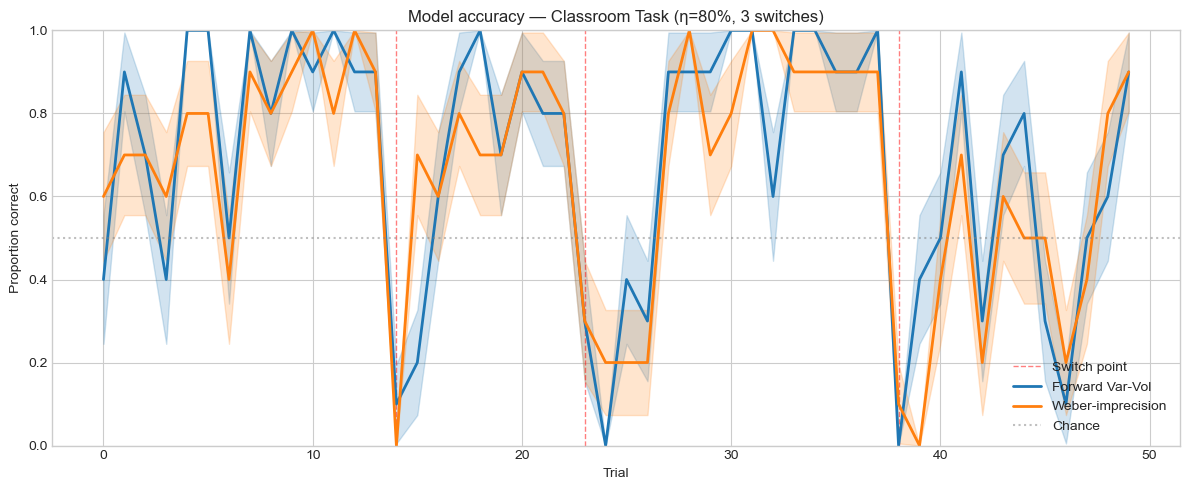

Switch points at trials: [14, 23, 38]
Mean accuracy — Var-Vol: 69.0%, Weber: 66.0%


In [94]:
# ============================================================
# ⚙️ SETTINGS
# ============================================================

FAST_MODE = True           # False = higher accuracy but slower
USE_CLASSROOM_TASK = True  # True = use fixed classroom task for human comparison
                           # False = use random volatile task

if FAST_MODE:
    # ~2-3 min: Good for demos
    N_THETA = 100
    N_STATE = 50
    N_RUNS = 10
else:
    # ~15-20 min: Better accuracy
    N_THETA = 200
    N_STATE = 100  
    N_RUNS = 20

# Choose task type
if USE_CLASSROOM_TASK:
    # 🎓 Fixed task matching human experiment
    task = generate_classroom_task(beta=0.8, seed=42)
    print("📋 Using CLASSROOM TASK (fixed structure for human comparison)")
    print("   Blocks: 14 trials → 9 trials → 15 trials → 12 trials")
    print("   Switches at trials: 15, 24, 39")
else:
    # Random volatile task
    task = generate_bandit_task(trial_num=50, beta=0.8, seed=123)
    print("🎲 Using RANDOM TASK (volatile, τ random walk)")

print(f"   Particles: {N_THETA}×{N_STATE} = {N_THETA*N_STATE:,}")
print(f"   Runs: {N_RUNS}")

varvol_result = simulate_agent(
    ForwardVaryingVolatilityAgent,
    task,
    runs=N_RUNS,
    agent_kwargs={
        "num_theta": N_THETA,
        "num_state_particles": N_STATE,
        "beta_softmax": 4.0, 
        "epsilon_softmax": 0.05
    },
)
weber_result = simulate_agent(
    WeberImprecisionAgent,
    task,
    runs=N_RUNS,
    agent_kwargs={
        "num_theta": N_THETA,
        "num_state_particles": N_STATE,
        "lambdaa": 0.8, 
        "mu": 0.1, 
        "beta_softmax": 4.0, 
        "epsilon_softmax": 0.05
    },
)

acc_varvol = varvol_result["correct"].mean(axis=0)
sem_varvol = varvol_result["correct"].std(axis=0) / np.sqrt(varvol_result["correct"].shape[0])
acc_weber = weber_result["correct"].mean(axis=0)
sem_weber = weber_result["correct"].std(axis=0) / np.sqrt(weber_result["correct"].shape[0])

# Find switch points (where latent state changes)
switches = np.where(np.diff(task.latent_states) != 0)[0] + 1

plt.figure(figsize=(12, 5))
trials = np.arange(len(acc_varvol))

# Plot switch points as vertical lines
for i, sw in enumerate(switches):
    plt.axvline(sw, color="red", linestyle="--", alpha=0.5, linewidth=1,
                label="Switch point" if i == 0 else None)

# Plot model accuracy
plt.plot(trials, acc_varvol, label="Forward Var-Vol", color="#1f77b4", linewidth=2)
plt.fill_between(trials, acc_varvol - sem_varvol, acc_varvol + sem_varvol, alpha=0.2, color="#1f77b4")
plt.plot(trials, acc_weber, label="Weber-imprecision", color="#ff7f0e", linewidth=2)
plt.fill_between(trials, acc_weber - sem_weber, acc_weber + sem_weber, alpha=0.2, color="#ff7f0e")

plt.axhline(0.5, color="gray", linestyle=":", alpha=0.5, label="Chance")
plt.xlabel("Trial")
plt.ylabel("Proportion correct")
plt.ylim(0, 1)
plt.legend(loc="lower right")
task_type = "Classroom Task" if USE_CLASSROOM_TASK else "Random Task"
plt.title(f"Model accuracy — {task_type} (η={task.beta:.0%}, {len(switches)} switches)")
plt.tight_layout()
plt.show()

print(f"Switch points at trials: {switches.tolist()}")
print(f"Mean accuracy — Var-Vol: {acc_varvol.mean():.1%}, Weber: {acc_weber.mean():.1%}")


# Section 3: Comparing with Classroom Data


You'll get one CSV per participant from your study platform. The helpers below will:
1. **Combine** all CSVs into one dataframe
2. **Compute** per-trial accuracy across all participants
3. **Plot** human data against model predictions
4. **Compare** how do model vs human's recover after a volatile event?

### Step 1: Combine all participant CSVs


### 🧠 To Do: Now things are going to get interesting...
1. Download the entire ExperimentData folder from Stud.IP onto your local computer (shouldn't be more than a few KB per person - so memory shouldn't be an issue)
2. If zipped - unzip the folder
3. Add the individual files into /participant_data (you can just drag and drop into the notebook subfolder)
4. Run the combine_participant_csvs function
5. Check you have a new file called 'combined_data.csv'

```
findling_notebook/
├── notebook.ipynb                 ← You are here!
├── images_and_figures/
└── participant_data/
    ├── experiment_data.csv        ← Individual participant files
    ├── experiment_data2.csv
    ├── ...
    ├── backup_combined_data.csv   ← In case nothing works, here is a backup data file
    └── combined_data.csv          ← Auto-generated combined file
```
Each CSV has a few NaN columns this is ok, check there are valid terms for the columns: `trialNumber`, `userChoice` (0=Orange, 1=Blue)and `trueState` (correct answer).


In [95]:
import glob
import os

def combine_participant_csvs(
    folder_path: str,
    pattern: str = "*.csv",
    participant_id_from: str = "filename",  # "filename" or "column"
    participant_col: str = "participant_id",
    save_combined: bool = True,
    output_filename: str = "combined_data.csv",
) -> pd.DataFrame:
    """
    Combine multiple participant CSV files into one dataframe.
    
    Parameters
    ----------
    folder_path : str
        Path to folder containing the CSV files
    pattern : str
        Glob pattern to match CSV files (default: "*.csv")
    participant_id_from : str
        How to get participant ID:
        - "filename": extract from filename (e.g., "participant_001.csv" → "participant_001")
        - "column": assume each CSV already has a participant_col column
    participant_col : str
        Name for the participant ID column in output
    save_combined : bool
        Whether to save the combined dataframe to a CSV
    output_filename : str
        Filename for the combined CSV (saved in folder_path)
    
    Returns
    -------
    pd.DataFrame
        Combined dataframe with all participants
    """
    # Find all matching CSV files
    csv_files = glob.glob(os.path.join(folder_path, pattern))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {folder_path} matching '{pattern}'")
    
    print(f"Found {len(csv_files)} CSV files:")
    for f in csv_files[:5]:
        print(f"  - {os.path.basename(f)}")
    if len(csv_files) > 5:
        print(f"  ... and {len(csv_files) - 5} more")
    
    # Load and combine
    all_dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        
        if participant_id_from == "filename":
            # Extract participant ID from filename (without extension)
            participant_id = os.path.splitext(os.path.basename(csv_file))[0]
            df[participant_col] = participant_id
        elif participant_id_from == "column":
            if participant_col not in df.columns:
                raise ValueError(f"Column '{participant_col}' not found in {csv_file}")
        
        all_dfs.append(df)
    
    combined = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\n✓ Combined {len(csv_files)} files → {len(combined)} total rows")
    print(f"  Participants: {combined[participant_col].nunique()}")
    print(f"  Columns: {list(combined.columns)}")
    
    if save_combined:
        output_path = os.path.join(folder_path, output_filename)
        combined.to_csv(output_path, index=False)
        print(f"  Saved to: {output_path}")
    
    return combined


In [96]:
DATA_FOLDER = "participant_data"  # folder containing all the CSVs

human_df = combine_participant_csvs(
    folder_path=DATA_FOLDER,
    pattern="*.csv",              # matches all CSV files
    participant_id_from="filename",  # uses filename as participant ID
    save_combined=True,           # saves combined_data.csv
)

# Preview the data
human_df.head()


Found 1 CSV files:
  - backup_combined_data.csv

✓ Combined 1 files → 100 total rows
  Participants: 1
  Columns: ['trialNumber', 'stimulus', 'trueState', 'userChoice', 'outcome', 'reactionTime', 'isRuleChange', 'modelChoice', 'modelIsCorrect', 'participant_id']
  Saved to: participant_data\combined_data.csv


,trialNumber,stimulus,trueState,userChoice,outcome,reactionTime,isRuleChange,modelChoice,modelIsCorrect,participant_id
0,1,NaN,0,0,win,2371,False,NaN,NaN,backup_combined_data
1,2,NaN,0,0,win,471,False,NaN,NaN,backup_combined_data
2,3,NaN,0,0,win,310,False,NaN,NaN,backup_combined_data
3,4,NaN,0,0,loss,248,False,NaN,NaN,backup_combined_data
4,5,NaN,0,1,loss,718,False,NaN,NaN,backup_combined_data


### Step 2: Compute human accuracy per trial


In [97]:
def load_human_accuracy(
    csv_path: str,
    trial_col: str = "trialNumber",
    action_col: str = "userChoice",
    correct_col: str = "trueState",
    participant_col: Optional[str] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """Load a CSV and return mean ± SEM accuracy per trial."""
    df = pd.read_csv(csv_path)
    df = df.sort_values(by=[participant_col, trial_col] if participant_col else trial_col)
    df["correct"] = (df[action_col] == df[correct_col]).astype(float)

    if participant_col:
        grouped = df.groupby([participant_col, trial_col])["correct"].mean().reset_index()
        pivot = grouped.pivot(index=participant_col, columns=trial_col, values="correct")
    else:
        pivot = df.pivot(columns=trial_col, values="correct")

    mean = pivot.mean(axis=0).values
    sem = pivot.std(axis=0).values / np.sqrt(pivot.shape[0])
    trials = pivot.columns.to_numpy()
    return trials, mean, sem


### Step 3: Plot humans vs models


✓ Loaded human data: 50 trials


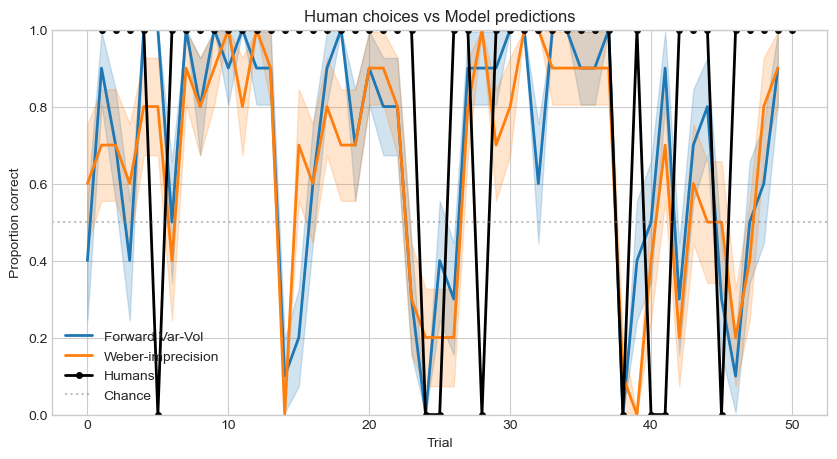

Human mean accuracy:   84.0%
Var-Vol mean accuracy: 69.0%
Weber mean accuracy:   66.0%


In [98]:

# Load human accuracy
trials_h, mean_h, sem_h = load_human_accuracy(
    csv_path="participant_data/combined_data.csv",
    trial_col="trialNumber",
    action_col="userChoice",
    correct_col="trueState",
    participant_col="participant_id",
)

print(f"✓ Loaded human data: {len(trials_h)} trials")

plt.figure(figsize=(10, 5))

# Plot model predictions (from simulation cell)
plt.plot(trials, acc_varvol, label="Forward Var-Vol", color="#1f77b4", linewidth=2)
plt.fill_between(trials, acc_varvol - sem_varvol, acc_varvol + sem_varvol, alpha=0.2, color="#1f77b4")
plt.plot(trials, acc_weber, label="Weber-imprecision", color="#ff7f0e", linewidth=2)
plt.fill_between(trials, acc_weber - sem_weber, acc_weber + sem_weber, alpha=0.2, color="#ff7f0e")

# Plot human data
plt.plot(trials_h, mean_h, "o-", color="black", linewidth=2, markersize=4, label="Humans")
plt.fill_between(trials_h, mean_h - sem_h, mean_h + sem_h, alpha=0.2, color="black")

plt.axhline(0.5, color="gray", linestyle=":", alpha=0.5, label="Chance")
plt.xlabel("Trial")
plt.ylabel("Proportion correct")
plt.legend()
plt.ylim(0, 1)
plt.title("Human choices vs Model predictions")
plt.show()

# Summary stats
print(f"Human mean accuracy:   {mean_h.mean():.1%}")
print(f"Var-Vol mean accuracy: {acc_varvol.mean():.1%}")
print(f"Weber mean accuracy:   {acc_weber.mean():.1%}")


### Step 4: Visualising how the agents recover after a volatile event
The helpers below show (a) a single run comparing chosen vs correct arms, and (b) average recovery after each switch.


In [99]:
def plot_action_timeline(task: VolatileBanditTask, sim_result: Dict[str, np.ndarray], agent_label: str, run_idx: int = 0):
    trials = np.arange(len(task.latent_states))
    correct_actions = task.correct_actions
    chosen = sim_result["actions"][run_idx]
    rewards = sim_result["rewards"][run_idx]
    switches = np.where(np.diff(task.latent_states) != 0)[0] + 0.5

    plt.figure(figsize=(10, 3))
    for sw in switches:
        plt.axvline(sw, color="gray", linestyle="--", alpha=0.3)
    plt.step(trials, correct_actions, where="post", label="Correct arm", linewidth=2, color="black")
    plt.scatter(trials, chosen, c=np.where(chosen == correct_actions, "#2ca02c", "#d62728"), label="Chosen arm")
    plt.yticks([0, 1], ["Arm 0", "Arm 1"])
    plt.xlabel("Trial")
    plt.title(f"{agent_label}: chosen vs correct arm (run {run_idx})")
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(10, 1.8))
    plt.scatter(trials, rewards, c=rewards, cmap="coolwarm", vmin=0, vmax=1)
    plt.yticks([0, 1], ["Feedback=0", "Feedback=1"])
    plt.xlabel("Trial")
    plt.title("Feedback received")
    plt.show()


def switch_aligned_accuracy(
    task: VolatileBanditTask, 
    sim_result: Dict[str, np.ndarray], 
    before: int = 5,      # trials BEFORE switch to include
    after: int = 12       # trials AFTER switch to include
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute average accuracy aligned to switch points.
    Returns x-axis (centered at 0 = switch trial), mean accuracy, and SEM.
    """
    switches = np.where(np.diff(task.latent_states) != 0)[0] + 1
    corr = sim_result["correct"]  # shape: (runs, trials)
    segments = []
    
    for sw in switches:
        if sw >= before and sw + after <= corr.shape[1]:
            segment = corr[:, sw - before : sw + after]
            segments.append(segment)
    
    if not segments:
        x = np.arange(-before, after)
        return x, np.zeros(len(x)), np.zeros(len(x))
    
    segments = np.stack(segments)  # (num_switches, runs, before+after)
    flat = segments.reshape(-1, segments.shape[-1])
    
    mean = flat.mean(axis=0)
    sem = flat.std(axis=0) / np.sqrt(flat.shape[0])
    x = np.arange(-before, after)
    
    return x, mean, sem


def switch_aligned_accuracy_human(
    human_df: pd.DataFrame,
    task: VolatileBanditTask,
    trial_col: str = "trialNumber",
    action_col: str = "userChoice",
    correct_col: str = "trueState",
    participant_col: str = "participant_id",
    before: int = 5,
    after: int = 12
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute switch-aligned accuracy for human data.
    Uses the same switch points from the task.
    """
    switches = np.where(np.diff(task.latent_states) != 0)[0] + 1
    
    df = human_df.copy()
    df["correct"] = (df[action_col] == df[correct_col]).astype(float)
    
    participants = df[participant_col].unique()
    segments = []
    
    for pid in participants:
        pdata = df[df[participant_col] == pid].sort_values(trial_col)
        corr_array = pdata["correct"].values
        
        for sw in switches:
            if sw >= before and sw + after <= len(corr_array):
                segment = corr_array[sw - before : sw + after]
                if len(segment) == before + after:
                    segments.append(segment)
    
    if not segments:
        x = np.arange(-before, after)
        return x, np.zeros(len(x)), np.zeros(len(x))
    
    segments = np.array(segments)
    mean = segments.mean(axis=0)
    sem = segments.std(axis=0) / np.sqrt(segments.shape[0])
    x = np.arange(-before, after)
    
    return x, mean, sem



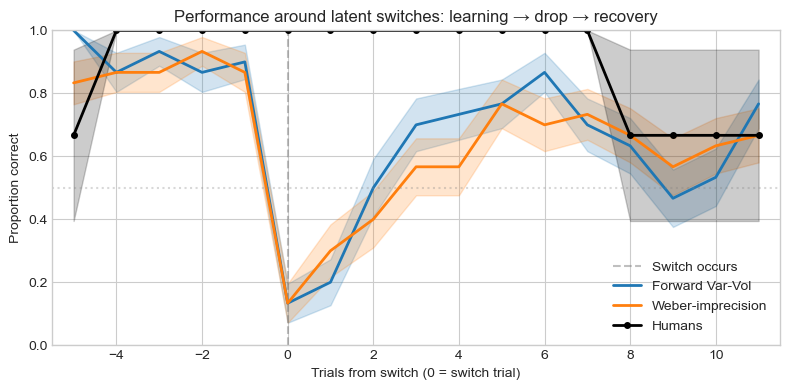

Switches found in task: 3


In [100]:
# Single-run timelines (use run 0 as a representative trajectory)
#plot_action_timeline(task, varvol_result, "Forward Var-Vol", run_idx=0)
#plot_action_timeline(task, weber_result, "Weber-imprecision", run_idx=0)

# ============================================================
# Switch-aligned accuracy: see learning BEFORE and recovery AFTER
# ============================================================
before = 5   # trials before switch (shows learned performance)
after = 12   # trials after switch (shows recovery)

# Model accuracy aligned to switches
x, mean_varvol_sw, sem_varvol_sw = switch_aligned_accuracy(task, varvol_result, before=before, after=after)
_, mean_weber_sw, sem_weber_sw = switch_aligned_accuracy(task, weber_result, before=before, after=after)

# Human accuracy aligned to switches (load combined data first!)
human_df = pd.read_csv("participant_data/combined_data.csv")
x_h, mean_human_sw, sem_human_sw = switch_aligned_accuracy_human(
    human_df, task, 
    trial_col="trialNumber", 
    action_col="userChoice", 
    correct_col="trueState",
    participant_col="participant_id",
    before=before, after=after
)

# Plot all three together
plt.figure(figsize=(8, 4))

# Vertical line at switch point
plt.axvline(0, color="gray", linestyle="--", alpha=0.5, label="Switch occurs")

# Models
plt.plot(x, mean_varvol_sw, label="Forward Var-Vol", color="#1f77b4", linewidth=2)
plt.fill_between(x, mean_varvol_sw - sem_varvol_sw, mean_varvol_sw + sem_varvol_sw, alpha=0.2, color="#1f77b4")
plt.plot(x, mean_weber_sw, label="Weber-imprecision", color="#ff7f0e", linewidth=2)
plt.fill_between(x, mean_weber_sw - sem_weber_sw, mean_weber_sw + sem_weber_sw, alpha=0.2, color="#ff7f0e")

# Humans
plt.plot(x_h, mean_human_sw, "o-", label="Humans", color="black", linewidth=2, markersize=4)
plt.fill_between(x_h, mean_human_sw - sem_human_sw, mean_human_sw + sem_human_sw, alpha=0.2, color="black")

plt.axhline(0.5, color="gray", linestyle=":", alpha=0.3)
plt.xlabel("Trials from switch (0 = switch trial)")
plt.ylabel("Proportion correct")
plt.ylim(0, 1)
plt.xlim(-before - 0.5, after - 0.5)
plt.title("Performance around latent switches: learning → drop → recovery")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Switches found in task: {len(np.where(np.diff(task.latent_states) != 0)[0])}")


### 🧠 To Do: Take-Away's 
1. Do you see stronger similarities between the Var-Vol to human, or Weber to human data?
2. Make sure you have clear in your head task accuracy vs behaviour fit - what we hope to see is a model that performs as *badly* in the same ways as human data. 
3. Did we manage to replicate the author's findings from Figure 5? 

<img src="images_and_figures/Fig5contingency_reversals.png" width="400" style="display:inline">



# The End!

Alright Folks! That's it for now - thanks for playing Volatile Bandits with us.

*If you have any questions of how you could incorporate the Weber-imprecision model (or noise generally) into your work for the mini-project at the end of the semester, please don't hesitate to each out to us on sascholle@uos.de.*

## Stay noisy, *Sabine, Sigur, Sofia and Elena*


